In [175]:
import random, cv2, os, importlib, sys, matplotlib.pyplot as plt, numpy as np
from PIL import Image
os.chdir('../lib')

import preprocess_images, get_bounding_box

importlib.reload(preprocess_images)
importlib.reload(get_bounding_box)
from preprocess_images import preprocess_rgb, preprocess_grayscale, preprocess_rgbd
from get_bounding_box import get_bounding_box

The preprocess_images file as 3 functions, each cooresponding to the file type. All 3 functions are void functions that return the variables listed below. There is also an "og" (original) variable wihtin the python script that is not returned that can be used to find the unaltered image.

Ex:

Preprocess_rgb = get all rgb image data

Preprocess_rgbd = get all image data infused with depth information on the blue color channel

Preprocess_grayscale = get all image data that is grayscale (based on depth map)

In [176]:
train_images, train_masks, val_images, val_masks, test_images, test_masks = preprocess_rgb('../data/useable_data', 70, 15, 15)

Number of Images: 274

Number of Train Images: 191
Number of Val Images: 41
Number of Test Images: 42


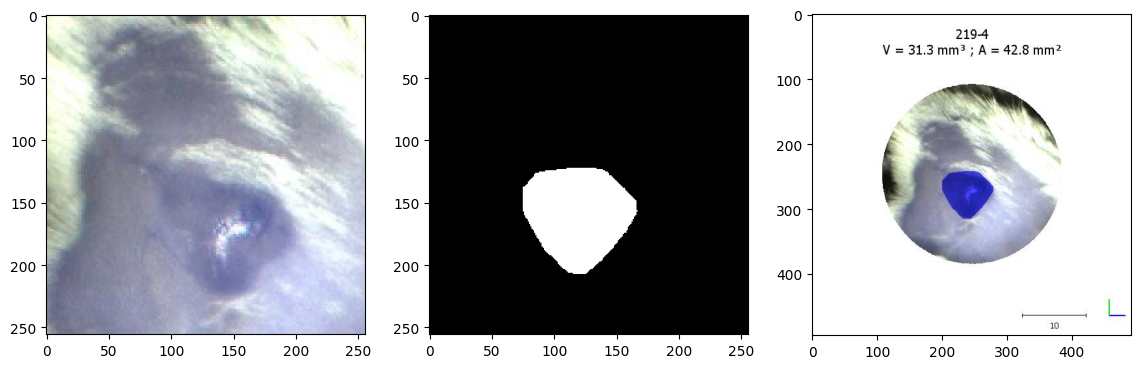

In [208]:
# santiy check
idx = random.randint(0, len(train_images))

fig, ax = plt.subplots(1, 3, figsize=[14,14])

ax[0].imshow(train_images[idx])
ax[1].imshow(train_masks[idx], cmap='gray')
ax[2].imshow(og[idx])

### Augmentation

In [39]:
def augment_image_array(image_array_raw, image_array_binary, num_augmentations):
    
    aug_raw = []
    aug_masks = []
    
    for _ in range(num_augmentations):
            for i in range(len(image_array_raw) -1):
                image_raw = image_array_raw[i]
                image_binary = image_array_binary[i]

                flipped_image_raw = cv2.flip(image_raw, 1)
                flipped_image_binary = cv2.flip(image_binary, 1)

                angle = random.uniform(-30, 30)
                (h, w) = flipped_image_raw.shape[:2]
                center = (w // 2, h // 2)

                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                augmented_image_raw = cv2.warpAffine(flipped_image_raw, M, (w, h))
                augmented_image_binary = cv2.warpAffine(flipped_image_binary, M, (w, h))

                aug_raw.append(augmented_image_raw)
                aug_masks.append(augmented_image_binary)

    image_array_raw = np.concatenate((image_array_raw, np.array(aug_raw)))
    image_array_binary = np.concatenate((image_array_binary, np.array(aug_masks)))

    return image_array_raw, image_array_binary

In [40]:
# apply augmentation to arrays 

train_images, train_masks = augment_image_array(train_images, train_masks, 100)
val_images, val_masks = augment_image_array(val_images, val_masks, 100)
test_images, test_masks = augment_image_array(test_images, test_masks, 10)

In [41]:
# print new lengths 

print(len(train_images))
print(len(val_images))
print(len(test_images))

2526
304
12


### Create Dataset

In [ ]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_images],
    "label": [Image.fromarray(mask) for mask in train_masks],
}

val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_images],
    "label": [Image.fromarray(mask) for mask in val_masks],
}

In [ ]:
from datasets import Dataset

# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(training_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor
from torch.utils.data import random_split, DataLoader
from transformers import SamModel
import monai
from torch.optim import Adam

processor = SamProcessor.from_pretrained("./medsam_pretrained/", local_files_only=True)

training_dataset = SAMDataset(dataset=training_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)

train_dataloader = DataLoader(dataset=training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False) 

# TODO: imoort medsam pretrained on della 
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)



### Training

In [ ]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# config 
num_epochs = 20
folder_path_model = ''

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    # Training loop
    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Logging training results
    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean(epoch_losses)}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(val_dataloader):
            # Forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_losses.append(loss.item())

    # Logging validation results
    print(f'Mean validation loss: {mean(val_losses)}')
    
# save model
torch.save(model.state_dict(), folder_path_model)